# AutoML Image Classification: 15m Challenge With Rotation (Digits)

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

![](imgs/rotation.png)

In [2]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [3]:
def get_data():
    random_state = RandomState(42)
    x, y = load_digits(return_X_y=True)
    y = y.astype(np.uint8)
    return train_test_split(x, y, test_size=1/7, random_state=random_state)
    # (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # s = x_train.shape[1]
    # x_train = x_train.reshape((len(x_train), s**2)).astype(np.float64)
    # x_test = x_test.reshape((len(x_test), s**2)).astype(np.float64)    
    # return x_train, x_test, y_train, y_test

In [4]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    # err_img_node = Array(reshape=(28, 28))

    err_root_node = Series(err_img_node)
    err_img_node.addfilter(RotationPIL("max_angle"))
    return err_root_node
    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(GaussianNoise("mean", "std"))
    # err_img_node.addfilter(Clip("min_val", "max_val"))
    # return err_root_node

In [5]:
def get_err_params_list(data):
    angle_steps = np.linspace(0, 180, num=6)
    err_params_list = [{"max_angle": a} for a in angle_steps]
    return err_params_list
    # min_val = np.amin(data)
    # max_val = np.amax(data)
    # std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    # err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    # return err_params_list

In [6]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data).astype(np.uint8), np.round(test_data).astype(np.uint8), {}

In [7]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 15
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        results = {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }
        print(type(fitted_model))
        print(results["test_acc"])
        return results

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            max_eval_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)

    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}", nthreads=20)
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s, 1))
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [8]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [9]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        err_param_name="max_angle",
        # err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [10]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.988

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.988

15.81 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.984

16.27 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.984

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpqgnbwui2

  JVM stdout: /wrk/users/thalvari/tmpqgnbwui2/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpqgnbwui2/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#226317166
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_886b closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.984

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpokza2l4k

  JVM stdout: /wrk/users/thalvari/tmpokza2l4k/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpokza2l4k/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#33716816
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_aef6 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.988

 17%|█▋        | 1/6 [1:34:32<7:52:44, 5672.82s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.899

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.72

19.98 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(KNeighborsClassifier(RandomForestClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.4, min_samples_leaf=10, min_samples_split=9, n_estimators=100), n_neighbors=22, p=2, weights=distance), n_neighbors=6, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.957

15.29 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.751

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp2adq5eq5

  JVM stdout: /wrk/users/thalvari/tmp2adq5eq5/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp2adq5eq5/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#987600363
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bd3b closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.938

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpqezg5pn9

  JVM stdout: /wrk/users/thalvari/tmpqezg5pn9/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpqezg5pn9/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#75722775
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9843 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.681

 33%|███▎      | 2/6 [3:12:41<6:22:30, 5737.60s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.883

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.44

21.80 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(BernoulliNB(GradientBoostingClassifier(input_matrix, learning_rate=0.001, max_depth=9, max_features=0.4, min_samples_leaf=20, min_samples_split=18, n_estimators=100, subsample=1.0), alpha=10.0, fit_prior=False), n_neighbors=18, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.86

15.75 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.514

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpv_kwl154

  JVM stdout: /wrk/users/thalvari/tmpv_kwl154/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpv_kwl154/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#919499638
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bb9f closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.872

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpw9_i72b4

  JVM stdout: /wrk/users/thalvari/tmpw9_i72b4/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpw9_i72b4/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#1046369838
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_88e1 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.428

 50%|█████     | 3/6 [4:53:07<4:51:12, 5824.08s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.786

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.381

15.19 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(LogisticRegression(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), C=15.0, dual=False, penalty=l2), learning_rate=0.1, max_depth=7, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.7000000000000001)

<class 'tpot.tpot.TPOTClassifier'>

0.879

15.32 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.416

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpkgdm7kvn

  JVM stdout: /wrk/users/thalvari/tmpkgdm7kvn/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpkgdm7kvn/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#967641848
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8646 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.891

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpao68puak

  JVM stdout: /wrk/users/thalvari/tmpao68puak/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpao68puak/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#99283850
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a22f closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.374

 67%|██████▋   | 4/6 [6:27:06<3:12:16, 5768.44s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.763

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.3

18.77 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(Normalizer(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), norm=max), C=20.0, dual=False, penalty=l2)

<class 'tpot.tpot.TPOTClassifier'>

0.844

15.40 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.346

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpxv6jl5zi

  JVM stdout: /wrk/users/thalvari/tmpxv6jl5zi/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpxv6jl5zi/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#1020712050
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9297 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.84

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpibxfn3lv

  JVM stdout: /wrk/users/thalvari/tmpibxfn3lv/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpibxfn3lv/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#761408563
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b33c closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.28

 83%|████████▎ | 5/6 [8:03:31<1:36:13, 5773.65s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.72

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.28

17.10 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), C=0.001, dual=True, penalty=l2)

<class 'tpot.tpot.TPOTClassifier'>

0.802

15.33 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l1), n_neighbors=12, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.342

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp7k7bfcb0

  JVM stdout: /wrk/users/thalvari/tmp7k7bfcb0/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp7k7bfcb0/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#13025913
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b3ac closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.844

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpjbirwgx9

  JVM stdout: /wrk/users/thalvari/tmpjbirwgx9/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpjbirwgx9/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#821344978
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_ad50 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.257

100%|██████████| 6/6 [9:38:01<00:00, 5742.40s/it]  

100%|██████████| 6/6 [9:38:01<00:00, 5780.22s/it]

'AutoKeras #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,0.999,0.191,0.001,903.505
36,0.899,0.992,0.217,0.002,904.79
72,0.883,0.989,0.206,0.001,910.706
108,0.786,0.984,0.213,0.001,919.599
144,0.763,0.971,0.225,0.001,910.781
180,0.72,0.948,0.213,0.001,919.802


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)"
36,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1),

'AutoKerasClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,0.999,0.191,0.001,903.215
36,0.72,0.999,0.217,0.002,905.413
72,0.44,0.999,0.206,0.001,905.272
108,0.381,0.999,0.213,0.001,904.891
144,0.3,0.999,0.225,0.001,922.529
180,0.28,0.999,0.213,0.001,913.534


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)"
36,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1),

'H2OAutoML #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.191,0.001,983.474
36,0.938,1,0.217,0.002,976.954
72,0.872,1,0.206,0.001,975.313
108,0.891,1,0.213,0.001,930.406
144,0.84,1,0.225,0.001,936.047
180,0.844,1,0.213,0.001,930.004


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99,pipe_100,pipe_101
0,StackedEnsemble_AllModels_AutoML_20191119_154255,DeepLearning_grid_1_AutoML_20191119_154255_model_9,DeepLearning_grid_1_AutoML_20191119_154255_model_6,DeepLearning_grid_1_AutoML_20191119_154255_model_2,GBM_grid_1_AutoML_20191119_154255_model_39,GBM_grid_1_AutoML_20191119_154255_model_31,GBM_grid_1_AutoML_20191119_154255_model_35,DeepLearning_grid_1_AutoML_20191119_154255_model_1,GBM_grid_1_AutoML_20191119_154255_model_18,GBM_grid_1_AutoML_20191119_154255_model_12,GBM_3_AutoML_20191119_154255,GBM_grid_1_AutoML_20191119_154255_model_27,GBM_grid_1_AutoML_20191119_154255_model_19,GBM_grid_1_AutoML_20191119_154255_model_40,XGBoost_grid_1_AutoML_20191119_154255_model_13,DeepLearning_grid_1_AutoML_20191119_154255_model_5,GBM_grid_1_AutoML_20191119_154255_model_1,GBM_grid_1_AutoML_20191119_154255_model_20,DeepLearning_grid_1_AutoML_20191119_154255_model_3,GBM_2_AutoML_20191119_154255,GBM_grid_1_AutoML_20191119_154255_model_15,DRF_1_AutoML_20191119_154255,GBM_4_AutoML_20191119_154255,XRT_1_AutoML_20191119_154255,GBM_grid_1_AutoML_20191119_154255_model_13,GBM_grid_1_AutoML_20191119_154255_model_32,GBM_grid_1_AutoML_20191119_154255_model_16,XGBoost_grid_1_AutoML_20191119_154255_model_8,GBM_grid_1_AutoML_20191119_154255_model_17,GBM_grid_1_AutoML_20191119_154255_model_41,GBM_grid_1_AutoML_20191119_154255_model_26,GBM_5_AutoML_20191119_154255,GBM_grid_1_AutoML_20191119_154255_model_6,GBM_grid_1_AutoML_20191119_154255_model_24,DeepLearning_grid_1_AutoML_20191119_154255_model_8,GBM_grid_1_AutoML_20191119_154255_model_10,GBM_grid_1_AutoML_20191119_154255_model_3,GBM_1_AutoML_20191119_154255,GLM_grid_1_AutoML_20191119_154255_model_1,XGBoost_grid_1_AutoML_20191119_154255_model_30,GBM_grid_1_AutoML_20191119_154255_model_14,XGBoost_3_AutoML_20191119_154255,XGBoost_grid_1_AutoML_20191119_154255_model_15,XGBoost_grid_1_AutoML_20191119_154255_model_17,GBM_grid_1_AutoML_20191119_154255_model_11,XGBoost_1_AutoML_20191119_154255,XGBoost_grid_1_AutoML_20191119_154255_model_25,GBM_grid_1_AutoML_20191119_154255_model_8,XGBoost_grid_1_AutoML_20191119_154255_model_4,XGBoost_grid_1_AutoML_20191119_154255_model_18,XGBoost_grid_1_AutoML_20191119_154255_model_21,XGBoost_grid_1_AutoML_20191119_154255_model_26,XGBoost_grid_1_AutoML_20191119_154255_model_2,XGBoost_grid_1_AutoML_20191119_154255_model_20,GBM_grid_1_AutoML_20191119_154255_model_9,XGBoost_grid_1_AutoML_20191119_154255_model_27,DeepLearning_grid_1_AutoML_20191119_154255_model_4,GBM_grid_1_AutoML_20191119_154255_model_42,GBM_grid_1_AutoML_20191119_154255_model_29,XGBoost_grid_1_AutoML_20191119_154255_model_3,XGBoost_grid_1_AutoML_20191119_154255_model_29,XGBoost_grid_1_AutoML_20191119_154255_model_28,DeepLearning_grid_1_AutoML_20191119_154255_model_7,GBM_grid_1_AutoML_20191119_154255_model_28,XGBoost_grid_1_AutoML_20191119_154255_model_31,XGBoost_grid_1_AutoML_20191119_154255_model_32,XGBoost_grid_1_AutoML_20191119_154255_model_33,GBM_grid_1_AutoML_20191119_154255_model_21,XGBoost_grid_1_AutoML_20191119_154255_model_7,XGBoost_grid_1_AutoML_20191119_154255_model_19,XGBoost_grid_1_AutoML_20191119_154255_model_23,GBM_grid_1_AutoML_20191119_154255_model_23,GBM_grid_1_AutoML_20191119_154255_model_30,XGBo

'H2OAutoMLClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,1,0.191,0.001,954.214
36,0.681,1,0.217,0.002,978.904
72,0.428,1,0.206,0.001,957.565
108,0.374,1,0.213,0.001,982.987
144,0.28,1,0.225,0.001,958.183
180,0.257,1,0.213,0.001,954.038


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99,pipe_100,pipe_101
0,StackedEnsemble_BestOfFamily_AutoML_20191119_155917,DeepLearning_grid_1_AutoML_20191119_155917_model_2,GBM_grid_1_AutoML_20191119_155917_model_39,XGBoost_grid_1_AutoML_20191119_155917_model_13,DRF_1_AutoML_20191119_155917,XRT_1_AutoML_20191119_155917,GLM_grid_1_AutoML_20191119_155917_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
36,StackedEnsemble_AllModels_AutoML_20191119_173702,DeepLearning_grid_1_AutoML_20191119_173702_model_2,GBM_grid_1_AutoML_20191119_173702_model_39,DeepLearning_grid_1_AutoML_20191119_173702_model_6,GBM_grid_1_AutoML_20191119_173702_model_31,GBM_grid_1_AutoML_20191119_173702_model_35,DeepLearning_grid_1_AutoML_20191119_173702_model_5,GBM_grid_1_AutoML_20191119_173702_model_18,DeepLearning_grid_1_AutoML_20191119_173702_model_1,GBM_grid_1_AutoML_20191119_173702_model_12,GBM_3_AutoML_20191119_173702,GBM_grid_1_AutoML_20191119_173702_model_27,DeepLearning_grid_1_AutoML_20191119_173702_model_9,GBM_grid_1_AutoML_20191119_173702_model_19,GBM_grid_1_AutoML_20191119_173702_model_40,XGBoost_grid_1_AutoML_20191119_173702_model_13,GBM_grid_1_AutoML_20191119_173702_model_1,GBM_grid_1_AutoML_20191119_173702_model_20,GBM_2_AutoML_20191119_173702,GBM_grid_1_AutoML_20191119_173702_model_15,DRF_1_AutoML_20191119_173702,GBM_4_AutoML_20191119_173702,XRT_1_AutoML_20191119_173702,GBM_grid_1_AutoML_20191119_173702_model_13,GBM_grid_1_AutoML_20191119_173702_model_32,GBM_grid_1_AutoML_20191119_173702_model_16,XGBoost_grid_1_AutoML_20191119_173702_model_8,GBM_grid_1_AutoML_20191119_173702_model_17,DeepLearning_grid_1_AutoML_20191119_173702_model_3,GBM_grid_1_AutoML_20191119_173702_model_26,DeepLearning_grid_1_AutoML_20191119_173702_model_8,GBM_5_AutoML_20191119_173702,GBM_grid_1_AutoML_20191119_173702_model_6,GBM_grid_1_AutoML_20191119_173702_model_24,GBM_grid_1_AutoML_20191119_173702_model_10,GBM_grid_1_AutoML_20191119_173702_model_3,GBM_1_AutoML_20191119_173702,GLM_grid_1_AutoML_20191119_173702_model_1,XGBoost_grid_1_AutoML_20191119_173702_model_30,GBM_grid_1_AutoML_20191119_173702_model_14,XGBoost_3_AutoML_20191119_173702,XGBoost_grid_1_AutoML_20191119_173702_model_15,XGBoost_grid_1_AutoML_20191119_173702_model_17,GBM_grid_1_AutoML_20191119_173702_model_11,XGBoost_1_AutoML_20191119_173702,XGBoost_grid_1_AutoML_20191119_173702_model_25,GBM_grid_1_AutoML_20191119_173702_model_8,GBM_grid_1_AutoML_20191119_173702_model_41,XGBoost_grid_1_AutoML_20191119_173702_model_4,XGBoost_grid_1_AutoML_20191119_173702_model_18,XGBoost_grid_1_AutoML_20191119_173702_model_21,XGBoost_grid_1_AutoML_20191119_173702_model_26,XGBoost_grid_1_AutoML_20191119_173702_model_2,XGBoost_grid_1_AutoML_20191119_173702_model_20,GBM_grid_1_AutoML_20191119_173702_model_9,XGBoost_grid_1_AutoML_20191119_173702_model_27,DeepLearning_grid_1_AutoML_20191119_173702_model_10,GBM_grid_1_AutoML_20191119_173702_model_29,XGBoost_grid_1

'TPOTClassifier #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.191,0.001,950.099
36,0.957,1,0.217,0.002,1203.39
72,0.86,1,0.206,0.001,1330.3
108,0.879,1,0.213,0.001,980.083
144,0.844,1,0.225,0.001,1132.81
180,0.802,1,0.213,0.001,1030.39


max_angle,pipe_0,pipe_1,pipe_2
0,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')",nan
36,"StackingEstimator(estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.4, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=9, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))","StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=22, p=2, weights='distance'))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=6, p=2, weights='distance')"
72,"StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=9, max_features=0.4, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=20, min_samples_split=18, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","StackingEstimator(estimator=BernoulliNB(alpha=10.0, binarize=0.0, class_prior=None, fit_prior=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=18, p=2, weights='distance')"
108,"PolynomialFeatures(degree=2, include_bias=False, interaction_only=False, order='C')","StackingEstimator(estimator=LogisticRegression(C=15.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7, min_child_weight=18, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.7000000000000001, verbosity=1)"
144,"PolynomialFeatures(degree=2, include_bias=False, interaction_only=False, order='C')","Normalizer(copy=True, norm='max')","LogisticRegression(C=20.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)"
180,"PolynomialFeatures(degree=2, include_bias=False, interaction_only=False, order='C')","LogisticRegression(C=0.001, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan


'TPOTClassifierClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.191,0.001,977.805
36,0.751,1,0.217,0.002,918.773
72,0.514,1,0.206,0.001,946.171
108,0.416,1,0.213,0.001,920.151
144,0.346,1,0.225,0.001,925.353
180,0.342,1,0.213,0.001,921.336


max_angle,pipe_0,pipe_1
0,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')"
36,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')"
72,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')"
108,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')"
144,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')"
180,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=12, p=2, weights='distance')"


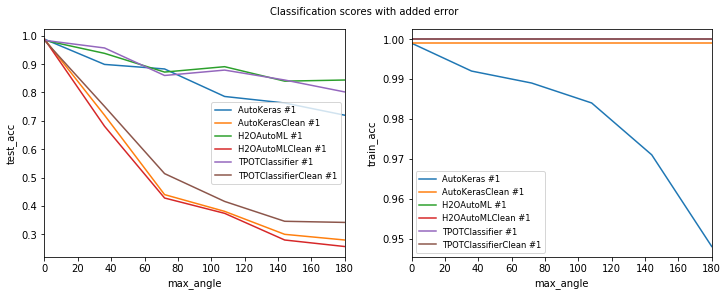

In [11]:
print_results_by_model(df,
    ["train_labels", "test_labels"],
    # ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    err_param_name="max_angle",
    # err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)